# Plots Comparing Regrets of Different Policy Ranking Methods

In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
# with open("../data/invalid_policy_list_20220705.json") as f:
#     invalid_policies = json.load(f)["invalid_policies"]
invalid_policies = []
def filter_policy_map(policy_map):
    ret_data = {}
    for policy in policy_map:
        if is_policy_valid(policy):
            ret_data[policy] = policy_map[policy]
    return ret_data

def is_policy_valid(policy_name):
    if "blind" in policy_name or policy_name in invalid_policies:
        return False
    else:
        return True
    
def convert_to_df(policy_map, col_names=["policy","zone","score"]):
    ret_df = pd.DataFrame(columns=col_names)
    for policy in policy_map:
        for zone in policy_map[policy]:
            score = policy_map[policy][zone]
            ret_df.loc[len(ret_df)] = [policy, zone, score]
    return ret_df

In [3]:
raw_scores_locs = {
    # "UCB: 1-Day Eval": "data/ucb_raw_scores_19_07_2022.pkl",
    "ZCP: GN*": "data/15zone/grad_norm/raw_scores/grad_norm_raw_scores_15_days_18_09_2022.pkl",
    # "ZCP: GN+IPW (30)": "data/grad_norm/raw_scores/grad_norm_raw_scores_30_days_02_08_2022_new_policies.pkl",
    "ZCP: SNIP*": "data/15zone/snip/raw_scores/snip_raw_scores_15_days_18_09_2022.pkl",
    # "ZCP: SNIP (30)": "data/snip/raw_scores/snip_raw_scores_30_days_02_08_2022.pkl",
    # "ZCP: Jacob-Cov": "data/15zone/jacob_cov/raw_scores/jacob_cov_raw_scores_15_days_18_09_2022.pkl",
    # "ZCP: JC (30)": "data/jacob_cov/raw_scores/jacob_cov_raw_scores_30_days_19_07_2022_new_policies.pkl",
    # "ZCP: Synflow": "data/15zone/synflow/raw_scores/synflow_raw_scores_15_days_18_09_2022.pkl",
    # "ZCP: Synflow (30)": "data/synflow/raw_scores/synflow_raw_scores_30_days_19_07_2022_new_policies.pkl",
    "OPE: IPW": "data/15zone/ipw/raw_scores/ipw_raw_scores_15_days_18_09_2022.pkl",
    # "OPE: IPW (30)": "data/ipw/raw_scores/ipw_raw_scores_30_days_19_07_2022_new_policies.pkl",
    "OPE: SNIPW": "data/15zone/snipw/raw_scores/snipw_raw_scores_15_days_19_09_2022.pkl",
    # "OPE: SNIPW (30)": "data/snipw/raw_scores/snipw_raw_scores_30_days_19_07_2022_new_policies.pkl",
    "OPE: GK": "data/15zone/ContinuousActionGaussian/raw_scores/GaussianKernel_0.3_15_days_06_09_2022.pkl",
    # "OPE: GK (30)": "data/ContinuousActionGaussian/raw_scores/continuous_action_gaussian_0.3_raw_scores_30_days_01_08_2022.pkl"
}

raw_scores = {}
for method, loc in tqdm(raw_scores_locs.items()):
    with open(loc, "rb") as f:
        policy_map = pickle.load(f)
        raw_scores[method] = convert_to_df(filter_policy_map(policy_map))

validation_data_loc = "../data/eval_data/evaluation_report_20220820.csv"
eval_df = pd.read_csv(validation_data_loc, header=None, names=["datetime","policy","zone","energy"])
eval_df_new = pd.DataFrame(columns=eval_df.columns)
for i, row in eval_df.iterrows():
    if is_policy_valid("../"+row["policy"]):
        eval_df_new.loc[len(eval_df_new)] = row
eval_df = eval_df_new

  0%|          | 0/5 [00:00<?, ?it/s]

## Regret For Policies Across all Zones

In [4]:
def calc_simple_regret(prediction, ground_truth, method):
    ground_truth = ground_truth.sort_values(by=["energy"])
    max_delta = max(ground_truth["energy"]) - min(ground_truth["energy"])
    
    if method.split(" ")[1] in ["Synflow"]:
        ascending = True
    elif method.split(" ")[1] in ["GN*", "SNIP*", "Jacob-Cov", "IPW", "SNIPW", "1-Day", "GK"]:
        ascending = False
    prediction = prediction.sort_values(by=["score"], ascending=ascending)
    
    
    best_policy_prediction = prediction["policy"].values[0][3:]

    best_score_ground_truth = ground_truth["energy"].values[0]
    predicted_best_policy_score = ground_truth[ground_truth["policy"] == best_policy_prediction]["energy"].values[0]
    regret = -best_score_ground_truth + predicted_best_policy_score
    return regret / max_delta

def calc_regret_at_k(prediction, ground_truth, method, k=5):
    ground_truth = ground_truth.sort_values(by=["energy"], ascending=True)
    max_delta = max(ground_truth["energy"]) - min(ground_truth["energy"])
    
    if method.split(" ")[1] in ["Synflow"]:
        ascending = True
    elif method.split(" ")[1] in ["GN*", "SNIP*", "Jacob-Cov", "IPW", "SNIPW", "1-Day", "GK"]:
        ascending = False
    prediction = prediction.sort_values(by=["score"], ascending=ascending)
    # prediction = prediction.sort_values(by=["score"])
    
    top_k_preds = prediction[:k]
    top_k_policies = []
    top_k_actual_vals = []
    for i, row in top_k_preds.iterrows():
        top_k_policies.append(row["policy"])
        policy = row["policy"][3:]
        actual_value = ground_truth[ground_truth["policy"] == policy]["energy"].values[0]
        top_k_actual_vals.append(actual_value)
    
    best_score_ground_truth = ground_truth["energy"].values[0]
    best_predicted_value_top_k = min(top_k_actual_vals)
    regret_at_k = -best_score_ground_truth + best_predicted_value_top_k
        
    return regret_at_k / max_delta

In [5]:
K = 5
dfs = []
for method in raw_scores:
    print(method)
    df = pd.DataFrame()
    methods = []
    regrets = []
    regrets_at_k = []
    for zone in eval_df["zone"].unique():
        if "Flex" in zone:
            continue
        zone_eval_df = eval_df[eval_df["zone"] == zone]
        zone_metric_df = raw_scores[method][raw_scores[method]["zone"] == zone]
        regret = calc_simple_regret(zone_metric_df, zone_eval_df, method)
        regret_at_k = calc_regret_at_k(zone_metric_df, zone_eval_df, method, k=K)
        methods.append(method)
        regrets.append(regret)
        regrets_at_k.append(regret_at_k)
    df["method"] = methods
    df["regret"] = regrets
    df["regret_at_k"] = regrets_at_k
    dfs.append(df.copy())
plot_df = pd.concat(dfs)

ZCP: GN*
ZCP: SNIP*
OPE: IPW
OPE: SNIPW
OPE: GK


In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}
plt.rc("font", **font)

([<matplotlib.axis.YTick at 0x137ee1db0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


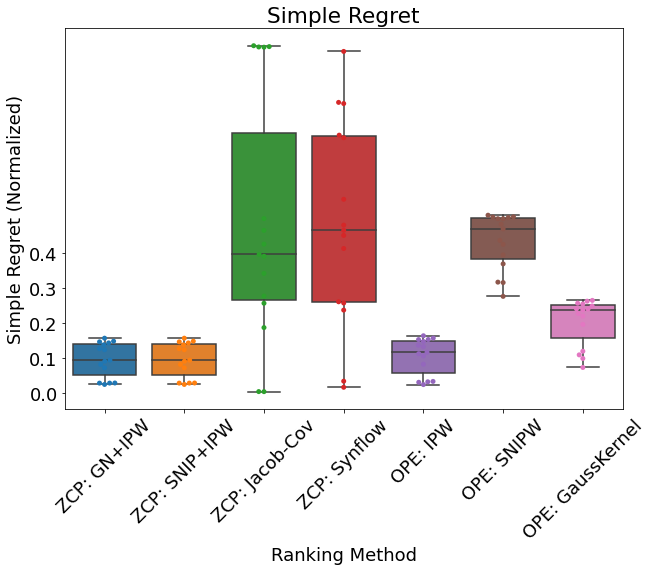

In [8]:
plt.figure(figsize=(8, 5))
plt.title("Simple Regret")
sns.boxplot(x="method", y="regret", data=plot_df)
sns.swarmplot(x="method", y="regret", data=plot_df)
plt.xlabel("Ranking Method")
plt.ylabel("Simple Regret (Normalized)")
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 0.41, step=0.1))
# plt.savefig("plots/simple_regret_11_08_2022_new_policies.pdf", dpi=300, bbox_inches="tight")

([<matplotlib.axis.YTick at 0x13c7e6d40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


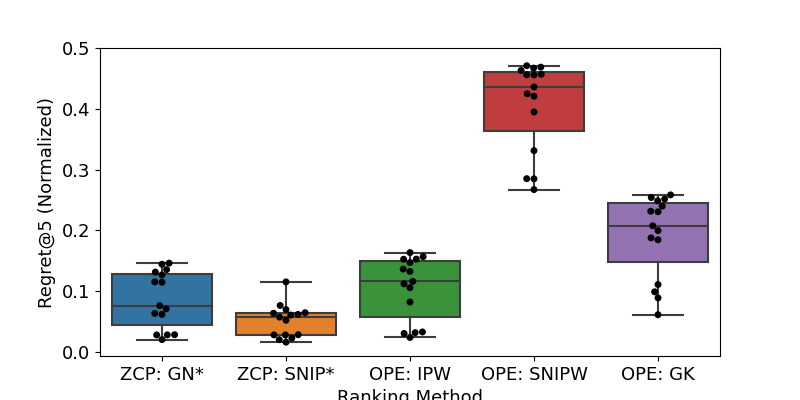

In [7]:
plt.figure(figsize=(8, 4))
# plt.title(f"Regret @ {K}")
sns.boxplot(x="method", y="regret_at_k", data=plot_df)
sns.swarmplot(x="method", y="regret_at_k", data=plot_df, color="black")
plt.xlabel("Ranking Method")
plt.ylabel(f"Regret@{K} (Normalized)")
# plt.xticks(rotation=45)
plt.yticks(np.arange(0, 0.6, step=0.1))

# plt.savefig(f"plots/regret@{K}_26_09_2022.pdf", dpi=300, bbox_inches="tight")

In [17]:
plot_df[plot_df["method"]=="ZCP: SNIP*"]["regret_at_k"].describe()

count    15.000000
mean      0.050794
std       0.027063
min       0.015838
25%       0.027814
50%       0.057133
75%       0.063917
max       0.115030
Name: regret_at_k, dtype: float64

In [19]:
[val for val in plot_df[plot_df["method"]=="ZCP: SNIP*"]["regret_at_k"].values]

[0.06349925980626907,
 0.11502956232836091,
 0.022563719089880297,
 0.057133213243856056,
 0.027840744978263388,
 0.028115882282267194,
 0.06046483793198235,
 0.06153312128118939,
 0.06433468007681847,
 0.051934460602722644,
 0.020060117015488006,
 0.02778683077873562,
 0.0695323775217111,
 0.01583827715616203,
 0.07624299211468284]